# Chapter 4 - Policy Gradient Methods

In [339]:
import numpy as np
import torch
import gym
from matplotlib import pyplot as plt
from torchsummary import summary
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [340]:
def running_mean(x, N=50):
    kernel = np.ones(N)
    conv_len = x.shape[0]-N
    y = np.zeros(conv_len)
    for i in range(conv_len):
        y[i] = kernel @ x[i:i+N]
        y[i] /= N
    return y

In [341]:
env = gym.make("CartPole-v0")

/usr/local/lib/python3.7/dist-packages/gym/envs/registration.py:594: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  f"The environment {id} is out of date. You should consider "
/usr/local/lib/python3.7/dist-packages/gym/core.py:318: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  "Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future."
/usr/local/lib/python3.7/dist-packages/gym/wrappers/step_api_compatibility.py:40: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in futu

##### Listing 4.4

In [356]:
import gym
import numpy as np
import torch

l1 = 4 #A
l2 = 150
l3 = 2 #B

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.fc1 = torch.nn.Linear(l1, l2)
        self.fc2 = torch.nn.Linear(l2, l3)
 
    def forward(self, x):
        x = self.fc1(x)
        x = torch.nn.LeakyReLU()(x)
        x = self.fc2(x)
        x = F.softmax(x, dim = 1)
        #x = torch.nn.Softmax(dim=0)(x)
        return x

model = Model()

learning_rate = 0.009
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

#A Input data is length 4
#B Output is a 2-length vector for the Left and the Right actions
#C Output is a softmax probability distribution over actions

In [271]:
# a = [[ 0.0456,  0.0263,  0.0084, -0.0402],
#         [ 0.0462, -0.1689,  0.0076,  0.2551],
#         [ 0.0428,  0.0261,  0.0127, -0.0351]]
a = [ 0.0442, -0.0435, -0.0458,  0.0188]
a = [a]
b = torch.FloatTensor(a)
model(b)

tensor([[0.5185, 0.4815]], grad_fn=<SoftmaxBackward0>)

##### Listing 4.5

In [209]:
state1 = env.reset()
pred = model(torch.from_numpy(state1).float()) #G
action = np.random.choice(np.array([0,1]), p=pred.data.numpy()) #H
state2, reward, done, info = env.step(action) #I

#G Call policy network model to produce predicted action probabilities
#H Sample an action from the probability distribution produced by the policy network
#I Take the action, receive new state and reward. The info variable is produced by the environment but is irrelevant

##### Listing 4.6

In [311]:
def discount_rewards(rewards, gamma=0.99):
    lenr = len(rewards)
    disc_return = torch.pow(gamma,torch.arange(lenr).float()) * rewards #A
    disc_return /= disc_return.max() #B
    return disc_return

#A Compute exponentially decaying rewards
#B Normalize the rewards to be within the [0,1] interval to improve numerical stability

##### Listing 4.7

In [312]:
def loss_fn(preds, r): #A
    return -1 * torch.sum(r * torch.log(preds)) #B

#A The loss function expects an array of action probabilities for the actions that were taken and the discounted rewards.
#B It computes the log of the probabilities, multiplies by the discounted rewards, sums them all and flips the sign.

In [201]:
model = torch.nn.Sequential(
    torch.nn.Linear(l1, l2),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(l2, l3),
    torch.nn.Softmax(dim=0) #C
)

In [230]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.fc1 = torch.nn.Linear(l1, l2)
        self.fc2 = torch.nn.Linear(l2, l3)
 
    def forward(self, x):
        x = self.fc1(x)
        x = torch.nn.LeakyReLU()(x)
        x = self.fc2(x)
        x = F.softmax(dim=0)(x)
        return x

model = Model()

In [187]:
print(model)

Sequential(
  (0): Linear(in_features=4, out_features=150, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=150, out_features=2, bias=True)
  (3): Softmax(dim=0)
)


In [191]:
print(model)

Model(
  (fc1): Linear(in_features=4, out_features=150, bias=True)
  (fc2): Linear(in_features=150, out_features=2, bias=True)
  (myFirstRelu): ReLU()
)


##### Listing 4.8

In [357]:
MAX_DUR = 200
MAX_EPISODES = 400
gamma = 0.99
score = [] #A
expectation = 0.0
for episode in range(MAX_EPISODES):
    curr_state = env.reset()
    done = False
    transitions = [] #B
    
    for t in range(MAX_DUR): #C
        #print(torch.from_numpy(curr_state).float())
        act_prob = model(torch.from_numpy(curr_state.reshape([1, -1])).float()) #D
        #print(act_prob)
        action = np.random.choice(np.array([0,1]), p=act_prob.data.numpy().flatten()) #E
        prev_state = curr_state
        curr_state, _, done, info = env.step(action) #F
        transitions.append((prev_state, action, t+1)) #G
        if done: #H
            break

    ep_len = len(transitions) #I
    score.append(ep_len)
    reward_batch = torch.Tensor([r for (s,a,r) in transitions]).flip(dims=(0,)) #J
    disc_returns = discount_rewards(reward_batch) #K
    state_batch = torch.Tensor([s for (s,a,r) in transitions]) #L
    action_batch = torch.Tensor([a for (s,a,r) in transitions]) #M
    pred_batch = model(state_batch) #N
    #print(pred_batch)
    prob_batch = pred_batch.gather(dim=1,index=action_batch.long().view(-1,1)).squeeze() #O
    loss = loss_fn(prob_batch, disc_returns)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

#A List to keep track of the episode length over training time
#B List of state, action, rewards (but we ignore the reward)
#C While in episode
#D Get the action probabilities
#E Select an action stochastically
#F Take the action in the environment
#G Store this transition
#H If game is lost, break out of the loop
#I Store the episode length
#J Collect all the rewards in the episode in a single tensor
#K Compute the discounted version of the rewards
#L Collect the states in the episode in a single tensor
#M Collect the actions in the episode in a single tensor
#N Re-compute the action probabilities for all the states in the episode
#O Subset the action-probabilities associated with the actions that were actually taken 

In [358]:
score = np.array(score)
avg_score = running_mean(score, 50)

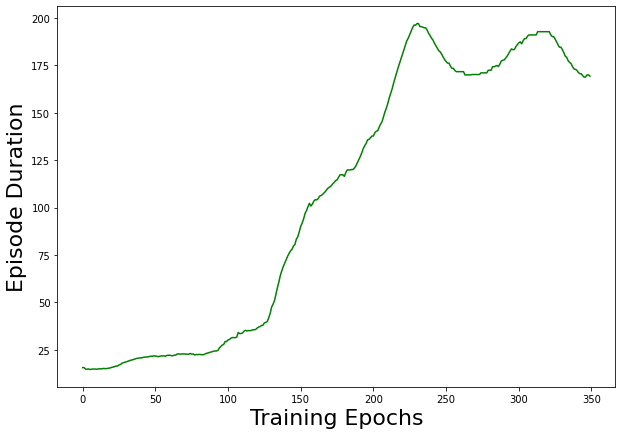

In [359]:
plt.figure(figsize=(10,7))
plt.ylabel("Episode Duration",fontsize=22)
plt.xlabel("Training Epochs",fontsize=22)
plt.plot(avg_score, color='green')

##### Listing 4.9

In [360]:
score = []
games = 100
done = False
state1 = env.reset()
for i in range(games):
    t=0
    while not done: #F
        pred = model(torch.from_numpy(state1.reshape([1, -1])).float()) #G
        action = np.random.choice(np.array([0,1]), p=pred.data.numpy().flatten()) #H
        state2, reward, done, info = env.step(action) #I
        state1 = state2 
        t += 1
        if t > MAX_DUR: #L
            break;
    state1 = env.reset()
    done = False
    score.append(t)
score = np.array(score)

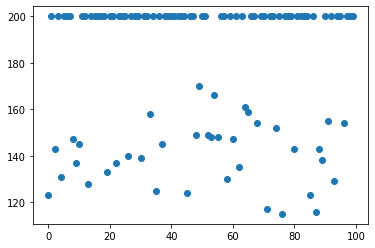

In [361]:
plt.scatter(np.arange(score.shape[0]),score)